In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


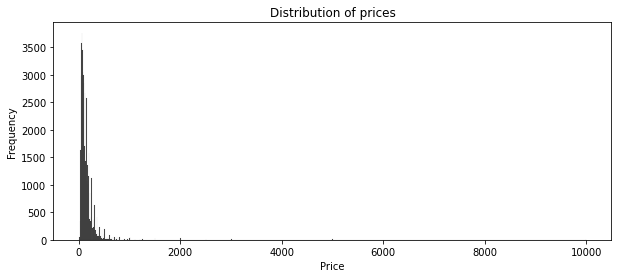

In [3]:
# Price plot 
plt.figure(figsize=(10, 4))

sns.histplot(df.price, bins=1000, color='black', alpha=0.7)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

In [4]:
vars = ['latitude','longitude','price','minimum_nights','number_of_reviews',
'reviews_per_month','calculated_host_listings_count','availability_365']

df_sm = df[vars]

In [5]:
# Question 1: Features with missing values
df_sm.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [6]:
# Question 2: median (50% percentile) for variable 'minimum_nights'
df_sm['minimum_nights'].median()

3.0

In [7]:
# Question 3: Split the data
np.random.seed(42)

n = len(df_sm)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_randoms = df_sm.iloc[idx]

df_train = df_randoms.iloc[:n_train].copy()
df_val = df_randoms.iloc[n_train:n_train+n_val].copy()
df_test = df_randoms.iloc[n_train+n_val:].copy()

In [8]:
# transform and delete price
y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

In [9]:
# Question 3: Linear regressions
base = ['latitude','longitude','minimum_nights','number_of_reviews',
'reviews_per_month','calculated_host_listings_count','availability_365']

# Fill values: Zero and Mean
def prepare_X(df, fill):
    df_num = df[base]
    df_num[['reviews_per_month']] = df_num[['reviews_per_month']].fillna(fill)
    X = df_num.values
    return X

# Regression
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

# RMSE 
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [10]:
# zero fills
X_train = prepare_X(df_train, 0)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, 0)
y_pred = w_0 + X_val.dot(w)
round(rmse(y_val, y_pred), 2)

0.64

In [11]:
# Mean fills
mean_value = df['reviews_per_month'].mean()

X_train = prepare_X(df_train, mean_value)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, mean_value)
y_pred = w_0 + X_val.dot(w)
round(rmse(y_val, y_pred), 2)

0.64

In [12]:
# Question 4: regularized linear regression

def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [13]:
X_train = prepare_X(df_train, 0)
X_val = prepare_X(df_val, 0)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, round(rmse(y_val, y_pred), 2))

     0 0.64
 1e-06 0.64
0.0001 0.64
 0.001 0.64
  0.01 0.66
   0.1 0.68
     1 0.68
     5 0.68
    10 0.68


In [14]:
# Question 5: Effects of seed

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


# Question 3: Split the data
def seededRegression(df, seedvalue):
    np.random.seed(seedvalue)
    n = len(df_sm)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_randoms = df_sm.iloc[idx]

    df_train = df_randoms.iloc[:n_train].copy()
    df_val = df_randoms.iloc[n_train:n_train+n_val].copy()
    df_test = df_randoms.iloc[n_train+n_val:].copy()
    
    X_train = prepare_X(df_train, 0)
    X_val = prepare_X(df_val, 0)
    
    w_0, w = train_linear_regression(X_train, y_train)
    y_pred = w_0 + X_val.dot(w)
    rmsval = rmse(y_val, y_pred)
    print('%6s' %seedvalue, rmsval)
    return rmsval

RMSE =[]
for seed in seeds:
    RMSE.append(seededRegression(df, seed))

     0 0.6942859839814093
     1 0.6943288864325332
     2 0.6939756256416206
     3 0.694176412213824
     4 0.6940576907563937
     5 0.6939842229664758
     6 0.6938331418019716
     7 0.6944719776229171
     8 0.6939852454798273
     9 0.6939787739841754


c:\users\alagat\miniconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [15]:
std = np.std(RMSE)
round(std, 3)

0.0

In [16]:
# Question 6: 
np.random.seed(9)

n = len(df_sm)

n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_randoms = df_sm.iloc[idx]

# combine train and validation
df_train = df_randoms.iloc[:n_train].copy()
df_test = df_randoms.iloc[n_train:].copy()

# transform and delete price
y_train_orig = df_train.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_test['price']

In [17]:
# fill with zeros
X_train = prepare_X(df_train, 0)
X_test = prepare_X(df_test, 0)

# r = 0.001
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
y_pred = w_0 + X_test.dot(w)
rmse(y_test, y_pred)

0.6447172399402562